# 케글 산탄데르 고객만족(Santandel Customer Satisfaction) 데이터 세트

### 케글 산탄데르 고객 만족 예측 대회

* 대회 개요
https://www.kaggle.com/c/santander-customer-satisfaction

- 불만고객(1) 분류하기
성능평가: ROC-AUC ( 대부분이 만족이고 불만족인 데이터는 소수인 불균형 데이터세트)

- 데이터셋 다운로드: 
https://www.kaggle.com/c/santander-customer-satisfaction/data

- 다운로드 후 데이터셋 이름 변경
train.csv -> train_santander.csv
test.csv -> test_santander.csv 

- XGBoost, LightGBM으로 예측

In [1]:
import numpy as np
import pandas as pd
santan_df = pd.read_csv("C:/Users/gihun/Python_data/data/santander/train.csv")
santan_df

,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
0,1,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39205.170000,0
1,3,2,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49278.030000,0
2,4,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,67333.770000,0
3,8,2,37,0.0,195.0,195.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,64007.970000,0
4,10,2,39,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117310.979016,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76015,151829,2,48,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,60926.490000,0
76016,151830,2,39,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,118634.520000,0
76017,151835,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,74028.150000,0
76018,151836,2,25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,84278.160000,0


In [12]:
santan_test_df = pd.read_csv("C:/Users/gihun/Python_data/data/santander/test.csv")

In [6]:
santan_df.isnull().sum().sum() # 결측치 없음

0

### 데이터 전처리

*  레이블 (Target) 의 분포 확인(불만족 고객 비율)

In [11]:
santan_df.TARGET.value_counts(normalize=True) # 타겟 비율

0    0.960431
1    0.039569
Name: TARGET, dtype: float64

In [ ]:
'''
var 컬럼: -9999, Nan이나 특정 예외값을 -9999로 처리했을 것.  -9999 값의 갯수확인
cust_df.var3.value_counts()[:10]하면 -9999가 116개 존재
-9999는 너무 편차가 심하므로 가장 많이 나타나는 2로 변환
ID : 단순 식별자에 불과하므로 drop
'''

In [14]:
santan_df.var3.value_counts()

 2         74165
 8           138
-999999      116
 9           110
 3           108
           ...  
 231           1
 188           1
 168           1
 135           1
 87            1
Name: var3, Length: 208, dtype: int64

In [15]:
santan_df['var3'] = santan_df['var3'].replace(-999999, 2)

In [17]:
santan_df.var3.value_counts()

2      74281
8        138
9        110
3        108
1        105
       ...  
231        1
188        1
168        1
135        1
87         1
Name: var3, Length: 207, dtype: int64

In [51]:
# var3 피처 값 대체 및 ID 피처 드롭
# 피처 세트와 레이블 세트분리. 
x=santan_df.drop(['ID','TARGET'],axis=1).values
y=santan_df.TARGET.values

In [52]:
# train, test set 분리: test_size=0.2, random_state=0
# 불균형 데이터이므로 학습세트와 테스트세트에 레이블 분포가 유사한지 확인
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x,y,test_size=0.2, random_state=0, stratify=y)

In [53]:
y_train.sum()/len(y_train), y_test.sum()/len(y_test)

(0.039561957379636935, 0.03959484346224678)

## 1. XGBoost 모델 

### XGBoost 모델 학습

In [54]:
from xgboost import XGBClassifier
xgb = XGBClassifier(n_estimators=500, random_state=156) # n_estimators=500, random state=156
xgb.fit(X_train, y_train,early_stopping_rounds=100,eval_metric='auc',eval_set=[(X_train, y_train),(X_test,y_test)],verbose=True)

c:\Users\gihun\Python_Data\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\gihun\Python_Data\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.82570	validation_1-auc:0.79283
[1]	validation_0-auc:0.84010	validation_1-auc:0.80737
[2]	validation_0-auc:0.84361	validation_1-auc:0.81021
[3]	validation_0-auc:0.84783	validation_1-auc:0.81287
[4]	validation_0-auc:0.85123	validation_1-auc:0.81469
[5]	validation_0-auc:0.85518	validation_1-auc:0.81860
[6]	validation_0-auc:0.85922	validation_1-auc:0.81977
[7]	validation_0-auc:0.86238	validation_1-auc:0.82034
[8]	validation_0-auc:0.86570	validation_1-auc:0.82147
[9]	validation_0-auc:0.86798	validation_1-auc:0.82301
[10]	validation_0-auc:0.87104	validation_1-auc:0.82379
[11]	validation_0-auc:0.87448	validation_1-auc:0.82456
[12]	validation_0-auc:0.87687	validation_1-auc:0.82401
[13]	validation_0-auc:0.87918	validation_1-auc:0.82467
[14]	validation_0-auc:0.88081	validation_1-auc:0.82508
[15]	validation_0-auc:0.88331	validation_1-auc:0.82379
[16]	validation_0-auc:0.88569	validation_1-auc:0.82457
[17]	validation_0-auc:0.88674	validation_1-auc:0.82453
[18]	validation_0-au

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=500,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=156,
              reg_alpha=0, reg_lambda=1, ...)

In [55]:
from sklearn.metrics import accuracy_score,confusion_matrix,precision_score, recall_score, f1_score, roc_auc_score
y_pred_train = xgb.predict(X_train)
y_pred_test = xgb.predict(X_test)
print(accuracy_score(y_train,y_pred_train),accuracy_score(y_test,y_pred_test))

0.9611450933964746 0.9601420678768745


In [56]:
def get_eval_score(y_test, y_pred, y_pred_proba):
    confusion = confusion_matrix(y_test, y_pred)
    acc = accuracy_score(y_test, y_pred) # 정확도
    prec = precision_score(y_test, y_pred) # 정밀도
    recall = recall_score(y_test, y_pred) # 재현율
    f1 = f1_score(y_test, y_pred) # f1점수
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    
    print("-"* 100)
    print("오차행렬:")
    print(confusion)
    print("정확도: {:.4f} 정밀도: {:.4f} 재현율: {:.4f} F1:{:.4f} AUC: {:.4f}".\
          format(acc, prec,recall, f1, roc_auc ))
    return

In [57]:
get_eval_score(y_test,y_pred_test,xgb.predict_proba(X_test)[:,1])

----------------------------------------------------------------------------------------------------
오차행렬:
[[14597     5]
 [  601     1]]
정확도: 0.9601 정밀도: 0.1667 재현율: 0.0017 F1:0.0033 AUC: 0.8251


In [ ]:
# 성능 평가 지표를 auc로, 조기 중단 파라미터는 100으로 설정하고 학습 수행. 
#


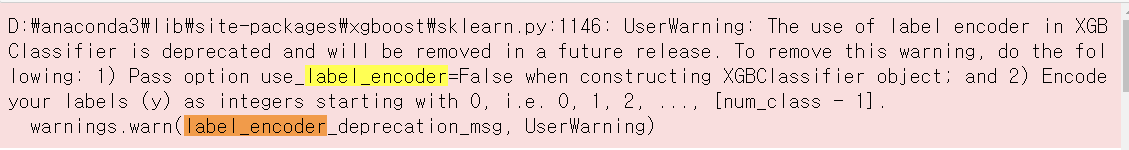

In [ ]:
# warning 제거를 위해 y_train, y_test 자료구조를 numpy로 바꿔줌

#### 첫 번째 하이퍼파라미터 튜닝 (0.8404 -> ?? )

In [58]:
from sklearn.model_selection import GridSearchCV

# 하이퍼 파라미터 테스트의 수행 속도를 향상시키기 위해 n_estimators를 100으로 감소
xgb = XGBClassifier(n_estimators=100, use_label_encoder=False)
params={'max_depth':[3,5,7], 'min_child_weight':[1,3], 'colsample_bytree':[0.5,0.75]}
grid=GridSearchCV(xgb, param_grid=params, cv=3)
grid.fit(X_train, y_train, early_stopping_rounds=30, eval_metric = 'auc', eval_set = [(X_train, y_train), (X_test, y_test)])
# cv는 3으로 지정 


c:\Users\gihun\Python_Data\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\gihun\Python_Data\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.78167	validation_1-auc:0.75531
[1]	validation_0-auc:0.80981	validation_1-auc:0.78496
[2]	validation_0-auc:0.81047	validation_1-auc:0.78302
[3]	validation_0-auc:0.81286	validation_1-auc:0.78341
[4]	validation_0-auc:0.81822	validation_1-auc:0.79186
[5]	validation_0-auc:0.82404	validation_1-auc:0.79802
[6]	validation_0-auc:0.81893	validation_1-auc:0.79352
[7]	validation_0-auc:0.83380	validation_1-auc:0.80727
[8]	validation_0-auc:0.83636	validation_1-auc:0.81062
[9]	validation_0-auc:0.83650	validation_1-auc:0.80634
[10]	validation_0-auc:0.83672	validation_1-auc:0.80491
[11]	validation_0-auc:0.83582	validation_1-auc:0.80253
[12]	validation_0-auc:0.84102	validation_1-auc:0.80882
[13]	validation_0-auc:0.84272	validation_1-auc:0.81227
[14]	validation_0-auc:0.84514	validation_1-auc:0.81422
[15]	validation_0-auc:0.84634	validation_1-auc:0.81429
[16]	validation_0-auc:0.84793	validation_1-auc:0.81640
[17]	validation_0-auc:0.84822	validation_1-auc:0.81762
[18]	validation_0-au

c:\Users\gihun\Python_Data\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\gihun\Python_Data\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.77859	validation_1-auc:0.75536
[1]	validation_0-auc:0.80861	validation_1-auc:0.77927
[2]	validation_0-auc:0.81131	validation_1-auc:0.78176
[3]	validation_0-auc:0.81275	validation_1-auc:0.78380
[4]	validation_0-auc:0.81951	validation_1-auc:0.79190
[5]	validation_0-auc:0.82311	validation_1-auc:0.79648
[6]	validation_0-auc:0.81850	validation_1-auc:0.79087
[7]	validation_0-auc:0.83194	validation_1-auc:0.80409
[8]	validation_0-auc:0.83487	validation_1-auc:0.80620
[9]	validation_0-auc:0.83431	validation_1-auc:0.80340
[10]	validation_0-auc:0.83355	validation_1-auc:0.80227
[11]	validation_0-auc:0.83356	validation_1-auc:0.79983
[12]	validation_0-auc:0.83934	validation_1-auc:0.80857
[13]	validation_0-auc:0.84306	validation_1-auc:0.81085
[14]	validation_0-auc:0.84495	validation_1-auc:0.81335
[15]	validation_0-auc:0.84614	validation_1-auc:0.81424
[16]	validation_0-auc:0.84740	validation_1-auc:0.81545
[17]	validation_0-auc:0.84839	validation_1-auc:0.81730
[18]	validation_0-au

c:\Users\gihun\Python_Data\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\gihun\Python_Data\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.79217	validation_1-auc:0.77106
[1]	validation_0-auc:0.80262	validation_1-auc:0.77748
[2]	validation_0-auc:0.81229	validation_1-auc:0.78963
[3]	validation_0-auc:0.81385	validation_1-auc:0.79136
[4]	validation_0-auc:0.81950	validation_1-auc:0.79731
[5]	validation_0-auc:0.82016	validation_1-auc:0.79590
[6]	validation_0-auc:0.81804	validation_1-auc:0.79463
[7]	validation_0-auc:0.82976	validation_1-auc:0.80664
[8]	validation_0-auc:0.83035	validation_1-auc:0.80648
[9]	validation_0-auc:0.83135	validation_1-auc:0.80812
[10]	validation_0-auc:0.83000	validation_1-auc:0.80442
[11]	validation_0-auc:0.83188	validation_1-auc:0.80450
[12]	validation_0-auc:0.83760	validation_1-auc:0.81032
[13]	validation_0-auc:0.83979	validation_1-auc:0.81323
[14]	validation_0-auc:0.84292	validation_1-auc:0.81672
[15]	validation_0-auc:0.84394	validation_1-auc:0.81675
[16]	validation_0-auc:0.84559	validation_1-auc:0.81903
[17]	validation_0-auc:0.84671	validation_1-auc:0.82016
[18]	validation_0-au

c:\Users\gihun\Python_Data\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\gihun\Python_Data\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.78158	validation_1-auc:0.75531
[1]	validation_0-auc:0.80907	validation_1-auc:0.78501
[2]	validation_0-auc:0.81145	validation_1-auc:0.78431
[3]	validation_0-auc:0.81388	validation_1-auc:0.78462
[4]	validation_0-auc:0.81895	validation_1-auc:0.79300
[5]	validation_0-auc:0.82434	validation_1-auc:0.79831
[6]	validation_0-auc:0.81889	validation_1-auc:0.79318
[7]	validation_0-auc:0.83571	validation_1-auc:0.81009
[8]	validation_0-auc:0.83654	validation_1-auc:0.81072
[9]	validation_0-auc:0.83676	validation_1-auc:0.80676
[10]	validation_0-auc:0.83720	validation_1-auc:0.80538
[11]	validation_0-auc:0.83662	validation_1-auc:0.80611
[12]	validation_0-auc:0.84190	validation_1-auc:0.81182
[13]	validation_0-auc:0.84329	validation_1-auc:0.81424
[14]	validation_0-auc:0.84417	validation_1-auc:0.81436
[15]	validation_0-auc:0.84617	validation_1-auc:0.81582
[16]	validation_0-auc:0.84750	validation_1-auc:0.81597
[17]	validation_0-auc:0.84829	validation_1-auc:0.81788
[18]	validation_0-au

c:\Users\gihun\Python_Data\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\gihun\Python_Data\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.77806	validation_1-auc:0.75536
[1]	validation_0-auc:0.80759	validation_1-auc:0.78214
[2]	validation_0-auc:0.81201	validation_1-auc:0.78361
[3]	validation_0-auc:0.81301	validation_1-auc:0.78467
[4]	validation_0-auc:0.82069	validation_1-auc:0.79346
[5]	validation_0-auc:0.82283	validation_1-auc:0.79635
[6]	validation_0-auc:0.82093	validation_1-auc:0.79455
[7]	validation_0-auc:0.83196	validation_1-auc:0.80528
[8]	validation_0-auc:0.83533	validation_1-auc:0.80777
[9]	validation_0-auc:0.83424	validation_1-auc:0.80370
[10]	validation_0-auc:0.83179	validation_1-auc:0.80079
[11]	validation_0-auc:0.83368	validation_1-auc:0.80309
[12]	validation_0-auc:0.83983	validation_1-auc:0.81094
[13]	validation_0-auc:0.84320	validation_1-auc:0.81425
[14]	validation_0-auc:0.84501	validation_1-auc:0.81589
[15]	validation_0-auc:0.84575	validation_1-auc:0.81642
[16]	validation_0-auc:0.84696	validation_1-auc:0.81764
[17]	validation_0-auc:0.84790	validation_1-auc:0.81925
[18]	validation_0-au

c:\Users\gihun\Python_Data\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\gihun\Python_Data\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.79188	validation_1-auc:0.77113
[1]	validation_0-auc:0.80897	validation_1-auc:0.78620
[2]	validation_0-auc:0.81528	validation_1-auc:0.79387
[3]	validation_0-auc:0.81675	validation_1-auc:0.79491
[4]	validation_0-auc:0.81910	validation_1-auc:0.79775
[5]	validation_0-auc:0.81985	validation_1-auc:0.79640
[6]	validation_0-auc:0.81786	validation_1-auc:0.79535
[7]	validation_0-auc:0.82936	validation_1-auc:0.80666
[8]	validation_0-auc:0.83020	validation_1-auc:0.80743
[9]	validation_0-auc:0.83117	validation_1-auc:0.80803
[10]	validation_0-auc:0.82992	validation_1-auc:0.80476
[11]	validation_0-auc:0.83159	validation_1-auc:0.80439
[12]	validation_0-auc:0.83750	validation_1-auc:0.81013
[13]	validation_0-auc:0.83973	validation_1-auc:0.81338
[14]	validation_0-auc:0.84286	validation_1-auc:0.81691
[15]	validation_0-auc:0.84401	validation_1-auc:0.81757
[16]	validation_0-auc:0.84542	validation_1-auc:0.81964
[17]	validation_0-auc:0.84653	validation_1-auc:0.82058
[18]	validation_0-au

c:\Users\gihun\Python_Data\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\gihun\Python_Data\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.81018	validation_1-auc:0.78188
[1]	validation_0-auc:0.82545	validation_1-auc:0.79768
[2]	validation_0-auc:0.83140	validation_1-auc:0.80216
[3]	validation_0-auc:0.83516	validation_1-auc:0.80198
[4]	validation_0-auc:0.83771	validation_1-auc:0.80506
[5]	validation_0-auc:0.84300	validation_1-auc:0.81035
[6]	validation_0-auc:0.84062	validation_1-auc:0.80790
[7]	validation_0-auc:0.84891	validation_1-auc:0.81507
[8]	validation_0-auc:0.85188	validation_1-auc:0.81522
[9]	validation_0-auc:0.85270	validation_1-auc:0.81168
[10]	validation_0-auc:0.85247	validation_1-auc:0.80830
[11]	validation_0-auc:0.85177	validation_1-auc:0.80637
[12]	validation_0-auc:0.85755	validation_1-auc:0.81189
[13]	validation_0-auc:0.86087	validation_1-auc:0.81560
[14]	validation_0-auc:0.86280	validation_1-auc:0.81838
[15]	validation_0-auc:0.86444	validation_1-auc:0.81759
[16]	validation_0-auc:0.86525	validation_1-auc:0.81930
[17]	validation_0-auc:0.86676	validation_1-auc:0.82054
[18]	validation_0-au

c:\Users\gihun\Python_Data\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\gihun\Python_Data\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.80190	validation_1-auc:0.77107
[1]	validation_0-auc:0.82224	validation_1-auc:0.79236
[2]	validation_0-auc:0.82855	validation_1-auc:0.79731
[3]	validation_0-auc:0.83272	validation_1-auc:0.80100
[4]	validation_0-auc:0.83879	validation_1-auc:0.80653
[5]	validation_0-auc:0.84195	validation_1-auc:0.80909
[6]	validation_0-auc:0.84137	validation_1-auc:0.80657
[7]	validation_0-auc:0.84732	validation_1-auc:0.81398
[8]	validation_0-auc:0.85179	validation_1-auc:0.81664
[9]	validation_0-auc:0.85311	validation_1-auc:0.81394
[10]	validation_0-auc:0.85239	validation_1-auc:0.81017
[11]	validation_0-auc:0.85279	validation_1-auc:0.80784
[12]	validation_0-auc:0.85759	validation_1-auc:0.81340
[13]	validation_0-auc:0.86136	validation_1-auc:0.81643
[14]	validation_0-auc:0.86298	validation_1-auc:0.81759
[15]	validation_0-auc:0.86409	validation_1-auc:0.81705
[16]	validation_0-auc:0.86491	validation_1-auc:0.81799
[17]	validation_0-auc:0.86655	validation_1-auc:0.81816
[18]	validation_0-au

c:\Users\gihun\Python_Data\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\gihun\Python_Data\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.80336	validation_1-auc:0.77696
[1]	validation_0-auc:0.82430	validation_1-auc:0.79852
[2]	validation_0-auc:0.83285	validation_1-auc:0.80769
[3]	validation_0-auc:0.83623	validation_1-auc:0.81104
[4]	validation_0-auc:0.84003	validation_1-auc:0.81154
[5]	validation_0-auc:0.83913	validation_1-auc:0.80673
[6]	validation_0-auc:0.83899	validation_1-auc:0.80485
[7]	validation_0-auc:0.84544	validation_1-auc:0.80996
[8]	validation_0-auc:0.84991	validation_1-auc:0.81530
[9]	validation_0-auc:0.85052	validation_1-auc:0.81157
[10]	validation_0-auc:0.85206	validation_1-auc:0.80830
[11]	validation_0-auc:0.85239	validation_1-auc:0.80717
[12]	validation_0-auc:0.85710	validation_1-auc:0.81409
[13]	validation_0-auc:0.86031	validation_1-auc:0.81699
[14]	validation_0-auc:0.86164	validation_1-auc:0.81783
[15]	validation_0-auc:0.86300	validation_1-auc:0.81652
[16]	validation_0-auc:0.86485	validation_1-auc:0.81957
[17]	validation_0-auc:0.86620	validation_1-auc:0.82128
[18]	validation_0-au

c:\Users\gihun\Python_Data\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\gihun\Python_Data\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.81016	validation_1-auc:0.78166
[1]	validation_0-auc:0.82562	validation_1-auc:0.79846
[2]	validation_0-auc:0.83299	validation_1-auc:0.80352
[3]	validation_0-auc:0.83448	validation_1-auc:0.80464
[4]	validation_0-auc:0.83803	validation_1-auc:0.80699
[5]	validation_0-auc:0.84222	validation_1-auc:0.81031
[6]	validation_0-auc:0.84076	validation_1-auc:0.80917
[7]	validation_0-auc:0.84800	validation_1-auc:0.81445
[8]	validation_0-auc:0.85033	validation_1-auc:0.81702
[9]	validation_0-auc:0.85129	validation_1-auc:0.81414
[10]	validation_0-auc:0.85203	validation_1-auc:0.81003
[11]	validation_0-auc:0.85056	validation_1-auc:0.80803
[12]	validation_0-auc:0.85584	validation_1-auc:0.81431
[13]	validation_0-auc:0.85874	validation_1-auc:0.81733
[14]	validation_0-auc:0.86039	validation_1-auc:0.81766
[15]	validation_0-auc:0.86168	validation_1-auc:0.81730
[16]	validation_0-auc:0.86311	validation_1-auc:0.81900
[17]	validation_0-auc:0.86405	validation_1-auc:0.81977
[18]	validation_0-au

c:\Users\gihun\Python_Data\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\gihun\Python_Data\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.80086	validation_1-auc:0.77134
[1]	validation_0-auc:0.82270	validation_1-auc:0.79361
[2]	validation_0-auc:0.82927	validation_1-auc:0.79856
[3]	validation_0-auc:0.83701	validation_1-auc:0.81021
[4]	validation_0-auc:0.84064	validation_1-auc:0.81159
[5]	validation_0-auc:0.84276	validation_1-auc:0.81091
[6]	validation_0-auc:0.84273	validation_1-auc:0.80946
[7]	validation_0-auc:0.84802	validation_1-auc:0.81573
[8]	validation_0-auc:0.85186	validation_1-auc:0.81745
[9]	validation_0-auc:0.85241	validation_1-auc:0.81444
[10]	validation_0-auc:0.85191	validation_1-auc:0.80997
[11]	validation_0-auc:0.85160	validation_1-auc:0.80854
[12]	validation_0-auc:0.85719	validation_1-auc:0.81449
[13]	validation_0-auc:0.86041	validation_1-auc:0.81682
[14]	validation_0-auc:0.86170	validation_1-auc:0.81865
[15]	validation_0-auc:0.86223	validation_1-auc:0.81810
[16]	validation_0-auc:0.86336	validation_1-auc:0.81981
[17]	validation_0-auc:0.86427	validation_1-auc:0.81930
[18]	validation_0-au

c:\Users\gihun\Python_Data\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\gihun\Python_Data\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.81057	validation_1-auc:0.78632
[1]	validation_0-auc:0.82979	validation_1-auc:0.80686
[2]	validation_0-auc:0.83353	validation_1-auc:0.81043
[3]	validation_0-auc:0.83822	validation_1-auc:0.81393
[4]	validation_0-auc:0.84095	validation_1-auc:0.81539
[5]	validation_0-auc:0.84153	validation_1-auc:0.81107
[6]	validation_0-auc:0.84116	validation_1-auc:0.80706
[7]	validation_0-auc:0.84847	validation_1-auc:0.81288
[8]	validation_0-auc:0.85140	validation_1-auc:0.81635
[9]	validation_0-auc:0.85185	validation_1-auc:0.81116
[10]	validation_0-auc:0.85156	validation_1-auc:0.80831
[11]	validation_0-auc:0.85131	validation_1-auc:0.80834
[12]	validation_0-auc:0.85553	validation_1-auc:0.81266
[13]	validation_0-auc:0.85886	validation_1-auc:0.81620
[14]	validation_0-auc:0.86079	validation_1-auc:0.81843
[15]	validation_0-auc:0.86184	validation_1-auc:0.81684
[16]	validation_0-auc:0.86330	validation_1-auc:0.81961
[17]	validation_0-auc:0.86458	validation_1-auc:0.82046
[18]	validation_0-au

c:\Users\gihun\Python_Data\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\gihun\Python_Data\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.82031	validation_1-auc:0.79118
[1]	validation_0-auc:0.83414	validation_1-auc:0.80055
[2]	validation_0-auc:0.83743	validation_1-auc:0.80321
[3]	validation_0-auc:0.84152	validation_1-auc:0.80461
[4]	validation_0-auc:0.84718	validation_1-auc:0.80869
[5]	validation_0-auc:0.85122	validation_1-auc:0.81150
[6]	validation_0-auc:0.85143	validation_1-auc:0.80762
[7]	validation_0-auc:0.86119	validation_1-auc:0.81223
[8]	validation_0-auc:0.86555	validation_1-auc:0.81523
[9]	validation_0-auc:0.86666	validation_1-auc:0.81064
[10]	validation_0-auc:0.86744	validation_1-auc:0.80571
[11]	validation_0-auc:0.86900	validation_1-auc:0.80273
[12]	validation_0-auc:0.87455	validation_1-auc:0.80680
[13]	validation_0-auc:0.87936	validation_1-auc:0.81005
[14]	validation_0-auc:0.88134	validation_1-auc:0.81139
[15]	validation_0-auc:0.88245	validation_1-auc:0.81039
[16]	validation_0-auc:0.88475	validation_1-auc:0.81181
[17]	validation_0-auc:0.88664	validation_1-auc:0.81336
[18]	validation_0-au

c:\Users\gihun\Python_Data\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\gihun\Python_Data\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.81340	validation_1-auc:0.78197
[1]	validation_0-auc:0.83354	validation_1-auc:0.79994
[2]	validation_0-auc:0.83892	validation_1-auc:0.80340
[3]	validation_0-auc:0.84315	validation_1-auc:0.80711
[4]	validation_0-auc:0.84977	validation_1-auc:0.81179
[5]	validation_0-auc:0.85268	validation_1-auc:0.81081
[6]	validation_0-auc:0.85382	validation_1-auc:0.80703
[7]	validation_0-auc:0.86158	validation_1-auc:0.81244
[8]	validation_0-auc:0.86567	validation_1-auc:0.81509
[9]	validation_0-auc:0.86756	validation_1-auc:0.81049
[10]	validation_0-auc:0.86820	validation_1-auc:0.80499
[11]	validation_0-auc:0.86904	validation_1-auc:0.80340
[12]	validation_0-auc:0.87395	validation_1-auc:0.81174
[13]	validation_0-auc:0.87750	validation_1-auc:0.81568
[14]	validation_0-auc:0.87863	validation_1-auc:0.81628
[15]	validation_0-auc:0.87979	validation_1-auc:0.81577
[16]	validation_0-auc:0.88093	validation_1-auc:0.81711
[17]	validation_0-auc:0.88306	validation_1-auc:0.81827
[18]	validation_0-au

c:\Users\gihun\Python_Data\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\gihun\Python_Data\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.81350	validation_1-auc:0.78157
[1]	validation_0-auc:0.83210	validation_1-auc:0.80236
[2]	validation_0-auc:0.84026	validation_1-auc:0.80923
[3]	validation_0-auc:0.84491	validation_1-auc:0.81224
[4]	validation_0-auc:0.85210	validation_1-auc:0.81697
[5]	validation_0-auc:0.85410	validation_1-auc:0.81152
[6]	validation_0-auc:0.85502	validation_1-auc:0.80849
[7]	validation_0-auc:0.86243	validation_1-auc:0.81302
[8]	validation_0-auc:0.86614	validation_1-auc:0.81508
[9]	validation_0-auc:0.86823	validation_1-auc:0.81076
[10]	validation_0-auc:0.86852	validation_1-auc:0.80495
[11]	validation_0-auc:0.86890	validation_1-auc:0.80265
[12]	validation_0-auc:0.87349	validation_1-auc:0.80838
[13]	validation_0-auc:0.87752	validation_1-auc:0.81119
[14]	validation_0-auc:0.87972	validation_1-auc:0.81168
[15]	validation_0-auc:0.88164	validation_1-auc:0.80994
[16]	validation_0-auc:0.88376	validation_1-auc:0.81302
[17]	validation_0-auc:0.88526	validation_1-auc:0.81388
[18]	validation_0-au

c:\Users\gihun\Python_Data\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\gihun\Python_Data\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.81917	validation_1-auc:0.79054
[1]	validation_0-auc:0.83371	validation_1-auc:0.80237
[2]	validation_0-auc:0.83966	validation_1-auc:0.80628
[3]	validation_0-auc:0.84137	validation_1-auc:0.80729
[4]	validation_0-auc:0.84640	validation_1-auc:0.81165
[5]	validation_0-auc:0.84899	validation_1-auc:0.81242
[6]	validation_0-auc:0.85023	validation_1-auc:0.80952
[7]	validation_0-auc:0.86012	validation_1-auc:0.81778
[8]	validation_0-auc:0.86366	validation_1-auc:0.81832
[9]	validation_0-auc:0.86322	validation_1-auc:0.81397
[10]	validation_0-auc:0.86371	validation_1-auc:0.80891
[11]	validation_0-auc:0.86403	validation_1-auc:0.80753
[12]	validation_0-auc:0.86965	validation_1-auc:0.81214
[13]	validation_0-auc:0.87385	validation_1-auc:0.81481
[14]	validation_0-auc:0.87588	validation_1-auc:0.81646
[15]	validation_0-auc:0.87683	validation_1-auc:0.81632
[16]	validation_0-auc:0.87860	validation_1-auc:0.81768
[17]	validation_0-auc:0.88008	validation_1-auc:0.81932
[18]	validation_0-au

c:\Users\gihun\Python_Data\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\gihun\Python_Data\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.81527	validation_1-auc:0.78584
[1]	validation_0-auc:0.83156	validation_1-auc:0.80004
[2]	validation_0-auc:0.83866	validation_1-auc:0.80479
[3]	validation_0-auc:0.84281	validation_1-auc:0.80826
[4]	validation_0-auc:0.84876	validation_1-auc:0.81493
[5]	validation_0-auc:0.85209	validation_1-auc:0.81219
[6]	validation_0-auc:0.85251	validation_1-auc:0.80656
[7]	validation_0-auc:0.85920	validation_1-auc:0.81278
[8]	validation_0-auc:0.86436	validation_1-auc:0.81594
[9]	validation_0-auc:0.86451	validation_1-auc:0.81010
[10]	validation_0-auc:0.86345	validation_1-auc:0.80571
[11]	validation_0-auc:0.86410	validation_1-auc:0.80601
[12]	validation_0-auc:0.86914	validation_1-auc:0.81168
[13]	validation_0-auc:0.87289	validation_1-auc:0.81496
[14]	validation_0-auc:0.87455	validation_1-auc:0.81703
[15]	validation_0-auc:0.87594	validation_1-auc:0.81647
[16]	validation_0-auc:0.87780	validation_1-auc:0.81818
[17]	validation_0-auc:0.87971	validation_1-auc:0.81900
[18]	validation_0-au

c:\Users\gihun\Python_Data\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\gihun\Python_Data\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.81665	validation_1-auc:0.78788
[1]	validation_0-auc:0.83578	validation_1-auc:0.80443
[2]	validation_0-auc:0.84235	validation_1-auc:0.81030
[3]	validation_0-auc:0.84297	validation_1-auc:0.81134
[4]	validation_0-auc:0.84814	validation_1-auc:0.81240
[5]	validation_0-auc:0.85031	validation_1-auc:0.80907
[6]	validation_0-auc:0.85210	validation_1-auc:0.80571
[7]	validation_0-auc:0.85927	validation_1-auc:0.80967
[8]	validation_0-auc:0.86421	validation_1-auc:0.81433
[9]	validation_0-auc:0.86538	validation_1-auc:0.81270
[10]	validation_0-auc:0.86488	validation_1-auc:0.80685
[11]	validation_0-auc:0.86398	validation_1-auc:0.80381
[12]	validation_0-auc:0.86871	validation_1-auc:0.80952
[13]	validation_0-auc:0.87264	validation_1-auc:0.81170
[14]	validation_0-auc:0.87470	validation_1-auc:0.81505
[15]	validation_0-auc:0.87649	validation_1-auc:0.81380
[16]	validation_0-auc:0.87808	validation_1-auc:0.81618
[17]	validation_0-auc:0.87988	validation_1-auc:0.81782
[18]	validation_0-au

c:\Users\gihun\Python_Data\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\gihun\Python_Data\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.80632	validation_1-auc:0.77783
[1]	validation_0-auc:0.80974	validation_1-auc:0.78192
[2]	validation_0-auc:0.81287	validation_1-auc:0.78441
[3]	validation_0-auc:0.81368	validation_1-auc:0.78592
[4]	validation_0-auc:0.82054	validation_1-auc:0.79441
[5]	validation_0-auc:0.82231	validation_1-auc:0.79500
[6]	validation_0-auc:0.82566	validation_1-auc:0.79738
[7]	validation_0-auc:0.82737	validation_1-auc:0.80096
[8]	validation_0-auc:0.82806	validation_1-auc:0.80072
[9]	validation_0-auc:0.83303	validation_1-auc:0.80529
[10]	validation_0-auc:0.83369	validation_1-auc:0.80438
[11]	validation_0-auc:0.83435	validation_1-auc:0.80592
[12]	validation_0-auc:0.83979	validation_1-auc:0.81193
[13]	validation_0-auc:0.84167	validation_1-auc:0.81344
[14]	validation_0-auc:0.84281	validation_1-auc:0.81467
[15]	validation_0-auc:0.84429	validation_1-auc:0.81637
[16]	validation_0-auc:0.84538	validation_1-auc:0.81647
[17]	validation_0-auc:0.84616	validation_1-auc:0.81762
[18]	validation_0-au

c:\Users\gihun\Python_Data\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\gihun\Python_Data\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.80563	validation_1-auc:0.77625
[1]	validation_0-auc:0.80851	validation_1-auc:0.77941
[2]	validation_0-auc:0.81696	validation_1-auc:0.78990
[3]	validation_0-auc:0.81958	validation_1-auc:0.79328
[4]	validation_0-auc:0.82294	validation_1-auc:0.79801
[5]	validation_0-auc:0.82368	validation_1-auc:0.79778
[6]	validation_0-auc:0.82913	validation_1-auc:0.80298
[7]	validation_0-auc:0.83051	validation_1-auc:0.80300
[8]	validation_0-auc:0.83285	validation_1-auc:0.80578
[9]	validation_0-auc:0.83569	validation_1-auc:0.80706
[10]	validation_0-auc:0.83735	validation_1-auc:0.80790
[11]	validation_0-auc:0.83785	validation_1-auc:0.80723
[12]	validation_0-auc:0.84141	validation_1-auc:0.81272
[13]	validation_0-auc:0.84371	validation_1-auc:0.81438
[14]	validation_0-auc:0.84482	validation_1-auc:0.81498
[15]	validation_0-auc:0.84647	validation_1-auc:0.81685
[16]	validation_0-auc:0.84776	validation_1-auc:0.81782
[17]	validation_0-auc:0.84892	validation_1-auc:0.81777
[18]	validation_0-au

c:\Users\gihun\Python_Data\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\gihun\Python_Data\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.80089	validation_1-auc:0.77663
[1]	validation_0-auc:0.81369	validation_1-auc:0.79141
[2]	validation_0-auc:0.81549	validation_1-auc:0.78826
[3]	validation_0-auc:0.81766	validation_1-auc:0.79150
[4]	validation_0-auc:0.82037	validation_1-auc:0.79692
[5]	validation_0-auc:0.82479	validation_1-auc:0.80029
[6]	validation_0-auc:0.82808	validation_1-auc:0.80242
[7]	validation_0-auc:0.82854	validation_1-auc:0.80302
[8]	validation_0-auc:0.83267	validation_1-auc:0.80870
[9]	validation_0-auc:0.83484	validation_1-auc:0.81088
[10]	validation_0-auc:0.83520	validation_1-auc:0.80833
[11]	validation_0-auc:0.83555	validation_1-auc:0.80818
[12]	validation_0-auc:0.83896	validation_1-auc:0.81187
[13]	validation_0-auc:0.84036	validation_1-auc:0.81343
[14]	validation_0-auc:0.84235	validation_1-auc:0.81633
[15]	validation_0-auc:0.84380	validation_1-auc:0.81765
[16]	validation_0-auc:0.84608	validation_1-auc:0.82018
[17]	validation_0-auc:0.84703	validation_1-auc:0.82086
[18]	validation_0-au

c:\Users\gihun\Python_Data\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\gihun\Python_Data\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.80745	validation_1-auc:0.78105
[1]	validation_0-auc:0.81030	validation_1-auc:0.78407
[2]	validation_0-auc:0.81379	validation_1-auc:0.78622
[3]	validation_0-auc:0.81544	validation_1-auc:0.78811
[4]	validation_0-auc:0.82092	validation_1-auc:0.79514
[5]	validation_0-auc:0.82726	validation_1-auc:0.80280
[6]	validation_0-auc:0.82739	validation_1-auc:0.80237
[7]	validation_0-auc:0.82875	validation_1-auc:0.80445
[8]	validation_0-auc:0.82985	validation_1-auc:0.80491
[9]	validation_0-auc:0.83420	validation_1-auc:0.80825
[10]	validation_0-auc:0.83424	validation_1-auc:0.80707
[11]	validation_0-auc:0.83422	validation_1-auc:0.80847
[12]	validation_0-auc:0.83927	validation_1-auc:0.81420
[13]	validation_0-auc:0.84091	validation_1-auc:0.81436
[14]	validation_0-auc:0.84229	validation_1-auc:0.81465
[15]	validation_0-auc:0.84395	validation_1-auc:0.81613
[16]	validation_0-auc:0.84519	validation_1-auc:0.81683
[17]	validation_0-auc:0.84624	validation_1-auc:0.81815
[18]	validation_0-au

c:\Users\gihun\Python_Data\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\gihun\Python_Data\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.80532	validation_1-auc:0.77772
[1]	validation_0-auc:0.80865	validation_1-auc:0.78039
[2]	validation_0-auc:0.81695	validation_1-auc:0.78860
[3]	validation_0-auc:0.81976	validation_1-auc:0.79252
[4]	validation_0-auc:0.82408	validation_1-auc:0.79847
[5]	validation_0-auc:0.82352	validation_1-auc:0.79682
[6]	validation_0-auc:0.82920	validation_1-auc:0.80298
[7]	validation_0-auc:0.83051	validation_1-auc:0.80298
[8]	validation_0-auc:0.83313	validation_1-auc:0.80582
[9]	validation_0-auc:0.83601	validation_1-auc:0.80723
[10]	validation_0-auc:0.83737	validation_1-auc:0.80843
[11]	validation_0-auc:0.83733	validation_1-auc:0.80623
[12]	validation_0-auc:0.84066	validation_1-auc:0.81139
[13]	validation_0-auc:0.84296	validation_1-auc:0.81467
[14]	validation_0-auc:0.84416	validation_1-auc:0.81529
[15]	validation_0-auc:0.84594	validation_1-auc:0.81639
[16]	validation_0-auc:0.84728	validation_1-auc:0.81710
[17]	validation_0-auc:0.84769	validation_1-auc:0.81763
[18]	validation_0-au

c:\Users\gihun\Python_Data\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\gihun\Python_Data\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.80200	validation_1-auc:0.77926
[1]	validation_0-auc:0.81623	validation_1-auc:0.79583
[2]	validation_0-auc:0.81803	validation_1-auc:0.79606
[3]	validation_0-auc:0.82048	validation_1-auc:0.79777
[4]	validation_0-auc:0.82054	validation_1-auc:0.79838
[5]	validation_0-auc:0.82427	validation_1-auc:0.80363
[6]	validation_0-auc:0.82732	validation_1-auc:0.80573
[7]	validation_0-auc:0.82828	validation_1-auc:0.80689
[8]	validation_0-auc:0.83003	validation_1-auc:0.80723
[9]	validation_0-auc:0.83441	validation_1-auc:0.81035
[10]	validation_0-auc:0.83565	validation_1-auc:0.80883
[11]	validation_0-auc:0.83643	validation_1-auc:0.80950
[12]	validation_0-auc:0.83942	validation_1-auc:0.81098
[13]	validation_0-auc:0.84176	validation_1-auc:0.81412
[14]	validation_0-auc:0.84293	validation_1-auc:0.81588
[15]	validation_0-auc:0.84500	validation_1-auc:0.81832
[16]	validation_0-auc:0.84603	validation_1-auc:0.82019
[17]	validation_0-auc:0.84721	validation_1-auc:0.81968
[18]	validation_0-au

c:\Users\gihun\Python_Data\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\gihun\Python_Data\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.81858	validation_1-auc:0.78761
[1]	validation_0-auc:0.82302	validation_1-auc:0.79326
[2]	validation_0-auc:0.83321	validation_1-auc:0.80485
[3]	validation_0-auc:0.83635	validation_1-auc:0.80627
[4]	validation_0-auc:0.83821	validation_1-auc:0.80698
[5]	validation_0-auc:0.84051	validation_1-auc:0.80839
[6]	validation_0-auc:0.84479	validation_1-auc:0.81310
[7]	validation_0-auc:0.84746	validation_1-auc:0.81415
[8]	validation_0-auc:0.85071	validation_1-auc:0.81566
[9]	validation_0-auc:0.85353	validation_1-auc:0.81646
[10]	validation_0-auc:0.85553	validation_1-auc:0.81325
[11]	validation_0-auc:0.85645	validation_1-auc:0.81063
[12]	validation_0-auc:0.85986	validation_1-auc:0.81491
[13]	validation_0-auc:0.86053	validation_1-auc:0.81678
[14]	validation_0-auc:0.86215	validation_1-auc:0.81761
[15]	validation_0-auc:0.86363	validation_1-auc:0.81874
[16]	validation_0-auc:0.86512	validation_1-auc:0.81924
[17]	validation_0-auc:0.86602	validation_1-auc:0.82091
[18]	validation_0-au

c:\Users\gihun\Python_Data\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\gihun\Python_Data\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.81566	validation_1-auc:0.78394
[1]	validation_0-auc:0.82348	validation_1-auc:0.78982
[2]	validation_0-auc:0.83405	validation_1-auc:0.80517
[3]	validation_0-auc:0.83708	validation_1-auc:0.80713
[4]	validation_0-auc:0.83836	validation_1-auc:0.80754
[5]	validation_0-auc:0.83989	validation_1-auc:0.80843
[6]	validation_0-auc:0.84602	validation_1-auc:0.81524
[7]	validation_0-auc:0.84900	validation_1-auc:0.81666
[8]	validation_0-auc:0.85078	validation_1-auc:0.81633
[9]	validation_0-auc:0.85439	validation_1-auc:0.81501
[10]	validation_0-auc:0.85539	validation_1-auc:0.81203
[11]	validation_0-auc:0.85631	validation_1-auc:0.80840
[12]	validation_0-auc:0.86035	validation_1-auc:0.81392
[13]	validation_0-auc:0.86296	validation_1-auc:0.81670
[14]	validation_0-auc:0.86386	validation_1-auc:0.81754
[15]	validation_0-auc:0.86518	validation_1-auc:0.81825
[16]	validation_0-auc:0.86615	validation_1-auc:0.81921
[17]	validation_0-auc:0.86731	validation_1-auc:0.81971
[18]	validation_0-au

c:\Users\gihun\Python_Data\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\gihun\Python_Data\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.81232	validation_1-auc:0.78399
[1]	validation_0-auc:0.82169	validation_1-auc:0.79494
[2]	validation_0-auc:0.83369	validation_1-auc:0.80739
[3]	validation_0-auc:0.83596	validation_1-auc:0.80871
[4]	validation_0-auc:0.83995	validation_1-auc:0.81172
[5]	validation_0-auc:0.84105	validation_1-auc:0.81099
[6]	validation_0-auc:0.84623	validation_1-auc:0.81538
[7]	validation_0-auc:0.84758	validation_1-auc:0.81518
[8]	validation_0-auc:0.85002	validation_1-auc:0.81826
[9]	validation_0-auc:0.85332	validation_1-auc:0.81769
[10]	validation_0-auc:0.85412	validation_1-auc:0.81517
[11]	validation_0-auc:0.85379	validation_1-auc:0.81176
[12]	validation_0-auc:0.85707	validation_1-auc:0.81459
[13]	validation_0-auc:0.86011	validation_1-auc:0.81778
[14]	validation_0-auc:0.86155	validation_1-auc:0.81936
[15]	validation_0-auc:0.86320	validation_1-auc:0.81883
[16]	validation_0-auc:0.86393	validation_1-auc:0.81969
[17]	validation_0-auc:0.86526	validation_1-auc:0.82079
[18]	validation_0-au

c:\Users\gihun\Python_Data\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\gihun\Python_Data\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.81740	validation_1-auc:0.79022
[1]	validation_0-auc:0.82740	validation_1-auc:0.79884
[2]	validation_0-auc:0.83295	validation_1-auc:0.80146
[3]	validation_0-auc:0.83449	validation_1-auc:0.80370
[4]	validation_0-auc:0.83895	validation_1-auc:0.80854
[5]	validation_0-auc:0.84142	validation_1-auc:0.81053
[6]	validation_0-auc:0.84576	validation_1-auc:0.81488
[7]	validation_0-auc:0.84778	validation_1-auc:0.81713
[8]	validation_0-auc:0.84973	validation_1-auc:0.81747
[9]	validation_0-auc:0.85302	validation_1-auc:0.81803
[10]	validation_0-auc:0.85449	validation_1-auc:0.81520
[11]	validation_0-auc:0.85401	validation_1-auc:0.81334
[12]	validation_0-auc:0.85779	validation_1-auc:0.81654
[13]	validation_0-auc:0.85929	validation_1-auc:0.81804
[14]	validation_0-auc:0.86067	validation_1-auc:0.81967
[15]	validation_0-auc:0.86171	validation_1-auc:0.82139
[16]	validation_0-auc:0.86292	validation_1-auc:0.82216
[17]	validation_0-auc:0.86354	validation_1-auc:0.82273
[18]	validation_0-au

c:\Users\gihun\Python_Data\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\gihun\Python_Data\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.81735	validation_1-auc:0.78665
[1]	validation_0-auc:0.82748	validation_1-auc:0.79597
[2]	validation_0-auc:0.83370	validation_1-auc:0.80543
[3]	validation_0-auc:0.83734	validation_1-auc:0.80804
[4]	validation_0-auc:0.83905	validation_1-auc:0.80760
[5]	validation_0-auc:0.84207	validation_1-auc:0.81112
[6]	validation_0-auc:0.84665	validation_1-auc:0.81593
[7]	validation_0-auc:0.84872	validation_1-auc:0.81764
[8]	validation_0-auc:0.85056	validation_1-auc:0.81722
[9]	validation_0-auc:0.85385	validation_1-auc:0.81838
[10]	validation_0-auc:0.85468	validation_1-auc:0.81452
[11]	validation_0-auc:0.85512	validation_1-auc:0.81354
[12]	validation_0-auc:0.85855	validation_1-auc:0.81689
[13]	validation_0-auc:0.86064	validation_1-auc:0.81913
[14]	validation_0-auc:0.86201	validation_1-auc:0.82067
[15]	validation_0-auc:0.86302	validation_1-auc:0.82135
[16]	validation_0-auc:0.86367	validation_1-auc:0.82130
[17]	validation_0-auc:0.86495	validation_1-auc:0.82157
[18]	validation_0-au

c:\Users\gihun\Python_Data\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\gihun\Python_Data\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.81423	validation_1-auc:0.78726
[1]	validation_0-auc:0.82967	validation_1-auc:0.80498
[2]	validation_0-auc:0.83684	validation_1-auc:0.80990
[3]	validation_0-auc:0.83964	validation_1-auc:0.81132
[4]	validation_0-auc:0.84111	validation_1-auc:0.81102
[5]	validation_0-auc:0.84234	validation_1-auc:0.81459
[6]	validation_0-auc:0.84650	validation_1-auc:0.81718
[7]	validation_0-auc:0.84877	validation_1-auc:0.81905
[8]	validation_0-auc:0.85022	validation_1-auc:0.82020
[9]	validation_0-auc:0.85295	validation_1-auc:0.81846
[10]	validation_0-auc:0.85351	validation_1-auc:0.81741
[11]	validation_0-auc:0.85373	validation_1-auc:0.81425
[12]	validation_0-auc:0.85663	validation_1-auc:0.81674
[13]	validation_0-auc:0.85886	validation_1-auc:0.81694
[14]	validation_0-auc:0.86044	validation_1-auc:0.81889
[15]	validation_0-auc:0.86171	validation_1-auc:0.81887
[16]	validation_0-auc:0.86238	validation_1-auc:0.81874
[17]	validation_0-auc:0.86333	validation_1-auc:0.81871
[18]	validation_0-au

c:\Users\gihun\Python_Data\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\gihun\Python_Data\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.82530	validation_1-auc:0.79157
[1]	validation_0-auc:0.83443	validation_1-auc:0.79525
[2]	validation_0-auc:0.84010	validation_1-auc:0.80004
[3]	validation_0-auc:0.84370	validation_1-auc:0.80236
[4]	validation_0-auc:0.84787	validation_1-auc:0.80527
[5]	validation_0-auc:0.85265	validation_1-auc:0.81015
[6]	validation_0-auc:0.85812	validation_1-auc:0.81266
[7]	validation_0-auc:0.86166	validation_1-auc:0.81590
[8]	validation_0-auc:0.86517	validation_1-auc:0.81637
[9]	validation_0-auc:0.86877	validation_1-auc:0.81747
[10]	validation_0-auc:0.87154	validation_1-auc:0.81423
[11]	validation_0-auc:0.87142	validation_1-auc:0.81163
[12]	validation_0-auc:0.87713	validation_1-auc:0.81491
[13]	validation_0-auc:0.88022	validation_1-auc:0.81550
[14]	validation_0-auc:0.88209	validation_1-auc:0.81798
[15]	validation_0-auc:0.88417	validation_1-auc:0.81926
[16]	validation_0-auc:0.88580	validation_1-auc:0.81852
[17]	validation_0-auc:0.88678	validation_1-auc:0.81953
[18]	validation_0-au

c:\Users\gihun\Python_Data\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\gihun\Python_Data\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.82055	validation_1-auc:0.78501
[1]	validation_0-auc:0.83442	validation_1-auc:0.79874
[2]	validation_0-auc:0.83681	validation_1-auc:0.79928
[3]	validation_0-auc:0.84360	validation_1-auc:0.80298
[4]	validation_0-auc:0.84960	validation_1-auc:0.80878
[5]	validation_0-auc:0.85261	validation_1-auc:0.81219
[6]	validation_0-auc:0.85652	validation_1-auc:0.81381
[7]	validation_0-auc:0.86218	validation_1-auc:0.81773
[8]	validation_0-auc:0.86536	validation_1-auc:0.81875
[9]	validation_0-auc:0.87060	validation_1-auc:0.81710
[10]	validation_0-auc:0.87224	validation_1-auc:0.81588
[11]	validation_0-auc:0.87268	validation_1-auc:0.81247
[12]	validation_0-auc:0.87696	validation_1-auc:0.81447
[13]	validation_0-auc:0.88041	validation_1-auc:0.81713
[14]	validation_0-auc:0.88166	validation_1-auc:0.81755
[15]	validation_0-auc:0.88289	validation_1-auc:0.81956
[16]	validation_0-auc:0.88373	validation_1-auc:0.81968
[17]	validation_0-auc:0.88445	validation_1-auc:0.82074
[18]	validation_0-au

c:\Users\gihun\Python_Data\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\gihun\Python_Data\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.81782	validation_1-auc:0.78941
[1]	validation_0-auc:0.82613	validation_1-auc:0.79719
[2]	validation_0-auc:0.84226	validation_1-auc:0.80849
[3]	validation_0-auc:0.84825	validation_1-auc:0.81000
[4]	validation_0-auc:0.85201	validation_1-auc:0.81161
[5]	validation_0-auc:0.85313	validation_1-auc:0.81203
[6]	validation_0-auc:0.85801	validation_1-auc:0.81421
[7]	validation_0-auc:0.86135	validation_1-auc:0.81539
[8]	validation_0-auc:0.86621	validation_1-auc:0.81988
[9]	validation_0-auc:0.86820	validation_1-auc:0.81696
[10]	validation_0-auc:0.86885	validation_1-auc:0.81368
[11]	validation_0-auc:0.86929	validation_1-auc:0.80975
[12]	validation_0-auc:0.87461	validation_1-auc:0.81382
[13]	validation_0-auc:0.87841	validation_1-auc:0.81523
[14]	validation_0-auc:0.88082	validation_1-auc:0.81607
[15]	validation_0-auc:0.88311	validation_1-auc:0.81571
[16]	validation_0-auc:0.88480	validation_1-auc:0.81775
[17]	validation_0-auc:0.88638	validation_1-auc:0.81777
[18]	validation_0-au

c:\Users\gihun\Python_Data\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\gihun\Python_Data\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.82371	validation_1-auc:0.79441
[1]	validation_0-auc:0.83219	validation_1-auc:0.79713
[2]	validation_0-auc:0.83924	validation_1-auc:0.80071
[3]	validation_0-auc:0.84164	validation_1-auc:0.80063
[4]	validation_0-auc:0.84779	validation_1-auc:0.80814
[5]	validation_0-auc:0.85254	validation_1-auc:0.81182
[6]	validation_0-auc:0.85837	validation_1-auc:0.81536
[7]	validation_0-auc:0.86045	validation_1-auc:0.81643
[8]	validation_0-auc:0.86396	validation_1-auc:0.81603
[9]	validation_0-auc:0.86661	validation_1-auc:0.81434
[10]	validation_0-auc:0.86841	validation_1-auc:0.81200
[11]	validation_0-auc:0.86837	validation_1-auc:0.81087
[12]	validation_0-auc:0.87315	validation_1-auc:0.81463
[13]	validation_0-auc:0.87582	validation_1-auc:0.81752
[14]	validation_0-auc:0.87757	validation_1-auc:0.81904
[15]	validation_0-auc:0.87913	validation_1-auc:0.82074
[16]	validation_0-auc:0.88078	validation_1-auc:0.82060
[17]	validation_0-auc:0.88150	validation_1-auc:0.82095
[18]	validation_0-au

c:\Users\gihun\Python_Data\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\gihun\Python_Data\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.82004	validation_1-auc:0.78748
[1]	validation_0-auc:0.83345	validation_1-auc:0.79688
[2]	validation_0-auc:0.83682	validation_1-auc:0.79909
[3]	validation_0-auc:0.84510	validation_1-auc:0.80708
[4]	validation_0-auc:0.85085	validation_1-auc:0.81161
[5]	validation_0-auc:0.85308	validation_1-auc:0.81278
[6]	validation_0-auc:0.85603	validation_1-auc:0.81354
[7]	validation_0-auc:0.86053	validation_1-auc:0.81571
[8]	validation_0-auc:0.86417	validation_1-auc:0.81667
[9]	validation_0-auc:0.86847	validation_1-auc:0.81525
[10]	validation_0-auc:0.86930	validation_1-auc:0.81084
[11]	validation_0-auc:0.86990	validation_1-auc:0.80906
[12]	validation_0-auc:0.87324	validation_1-auc:0.81078
[13]	validation_0-auc:0.87582	validation_1-auc:0.81393
[14]	validation_0-auc:0.87786	validation_1-auc:0.81482
[15]	validation_0-auc:0.87894	validation_1-auc:0.81736
[16]	validation_0-auc:0.87977	validation_1-auc:0.81808
[17]	validation_0-auc:0.88042	validation_1-auc:0.81832
[18]	validation_0-au

c:\Users\gihun\Python_Data\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\gihun\Python_Data\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.81647	validation_1-auc:0.78924
[1]	validation_0-auc:0.83512	validation_1-auc:0.80449
[2]	validation_0-auc:0.84357	validation_1-auc:0.80927
[3]	validation_0-auc:0.84553	validation_1-auc:0.81043
[4]	validation_0-auc:0.85017	validation_1-auc:0.81305
[5]	validation_0-auc:0.85214	validation_1-auc:0.81486
[6]	validation_0-auc:0.85534	validation_1-auc:0.81895
[7]	validation_0-auc:0.86086	validation_1-auc:0.81995
[8]	validation_0-auc:0.86417	validation_1-auc:0.82170
[9]	validation_0-auc:0.86845	validation_1-auc:0.81883
[10]	validation_0-auc:0.86827	validation_1-auc:0.81536
[11]	validation_0-auc:0.86915	validation_1-auc:0.81085
[12]	validation_0-auc:0.87304	validation_1-auc:0.81348
[13]	validation_0-auc:0.87588	validation_1-auc:0.81419
[14]	validation_0-auc:0.87842	validation_1-auc:0.81613
[15]	validation_0-auc:0.88027	validation_1-auc:0.81731
[16]	validation_0-auc:0.88153	validation_1-auc:0.81769
[17]	validation_0-auc:0.88211	validation_1-auc:0.81829
[18]	validation_0-au

c:\Users\gihun\Python_Data\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\gihun\Python_Data\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.80606	validation_1-auc:0.77857
[1]	validation_0-auc:0.81330	validation_1-auc:0.78677
[2]	validation_0-auc:0.82106	validation_1-auc:0.79644
[3]	validation_0-auc:0.82434	validation_1-auc:0.79770
[4]	validation_0-auc:0.82310	validation_1-auc:0.79658
[5]	validation_0-auc:0.82471	validation_1-auc:0.79842
[6]	validation_0-auc:0.83013	validation_1-auc:0.80377
[7]	validation_0-auc:0.83123	validation_1-auc:0.80488
[8]	validation_0-auc:0.83273	validation_1-auc:0.80385
[9]	validation_0-auc:0.83672	validation_1-auc:0.80855
[10]	validation_0-auc:0.83745	validation_1-auc:0.80937
[11]	validation_0-auc:0.83776	validation_1-auc:0.80792
[12]	validation_0-auc:0.84206	validation_1-auc:0.81407
[13]	validation_0-auc:0.84452	validation_1-auc:0.81707
[14]	validation_0-auc:0.84543	validation_1-auc:0.81797
[15]	validation_0-auc:0.84731	validation_1-auc:0.81922
[16]	validation_0-auc:0.84868	validation_1-auc:0.82071
[17]	validation_0-auc:0.84904	validation_1-auc:0.82088
[18]	validation_0-au

GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     gamma=None, gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None, ...),
             param_grid={'colsample_bytree': [0.5, 0.75],
                         'max_depth': [3, 5, 7], 'min_child_weight': [1, 3]})

In [59]:
grid.best_score_

0.9605202578268877

In [60]:
grid.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.75,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=3, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [61]:
grid.best_params_

{'colsample_bytree': 0.75, 'max_depth': 3, 'min_child_weight': 1}

In [62]:
roc_auc_score(y_test, grid.best_estimator_.predict_proba(X_test)[:,1])

0.8238791413909987

#### 두번째 하이퍼파라미터 튜닝.( 0. 8455 -> 0.8453)

In [ ]:
# n_estimators는 1000으로 증가시키고, learning_rate=0.02로 감소, reg_alpha=0.03으로 추가함. 

# evaluation metric을 auc로, early stopping은 200 으로 설정하고 학습 수행. 

# 하이퍼 파라미터 테스트의 수행 속도를 향상시키기 위해 n_estimators를 100으로 감소
xgb = XGBClassifier(n_estimators=1000, use_label_encoder=False)
params={'max_depth':[3,5,7], 'min_child_weight':[1,3], 'colsample_bytree':[0.5,0.75]}
grid=GridSearchCV(xgb, param_grid=params, cv=3)
grid.fit(X_train, y_train, early_stopping_rounds=30, eval_metric = 'auc', eval_set = [(X_train, y_train), (X_test, y_test)])
# cv는 3으로 지정 


*  특성 중요도시각화

<AxesSubplot: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

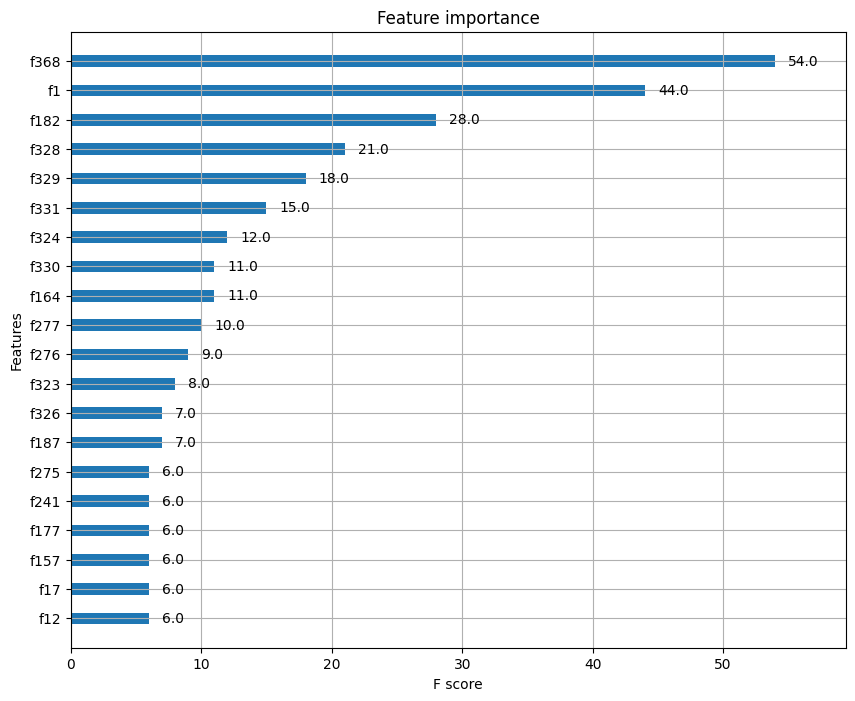

In [64]:
from xgboost import plot_importance
import matplotlib.pyplot as plt
xgb = grid.best_estimator_
fig, ax = plt.subplots(1,1,figsize=(10,8))
plot_importance(xgb, ax=ax, max_num_features=20, height=0.4)

## 2.  LightGBM 모델 

In [ ]:
from sklearn.model_selection import GridSearchCV

# 하이퍼 파라미터 테스트의 수행 속도를 향상시키기 위해 n_estimators를 100으로 감소
lgbm_clf = LGBMClassifier(n_estimators=200)

params = {'num_leaves': [32, 64 ],
          'max_depth':[128, 160],
          'min_child_samples':[60, 100],
          'subsample':[0.8, 1]}

# cv는 3으로 지정 
gridcv = GridSearchCV(lgbm_clf, param_grid=params, cv=3)

In [ ]:
?LGBMClassifier.fit

####  첫번째 하이퍼 파라미터 튜닝(0.8409 -> ? 0.8417)

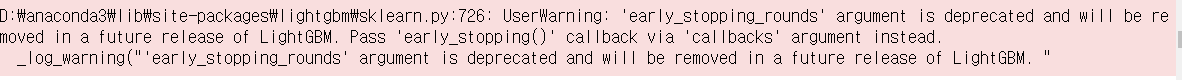

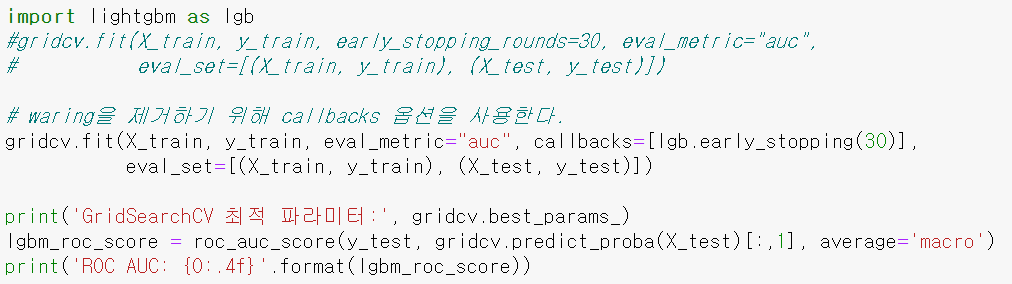